In [ ]:
# ============================================================
# 0. Install and import libraries
# ============================================================
!pip install xlrd openpyxl statsmodels --quiet

import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams["figure.figsize"] = (8, 4)


In [ ]:
# ============================================================
# 1. Upload data file (from your computer)
# ============================================================
print("Please upload your Excel file (e.g. Data.xls)...")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(f"\nLoaded file: {file_name}")

# Read Excel file
df_raw = pd.read_excel(io.BytesIO(uploaded[file_name]))
print("\nFirst 5 rows of your RAW data:")
display(df_raw.head())

print("\nRAW column names:")
print(df_raw.columns.tolist())


Please upload your Excel file (e.g. Data.xls)...


Saving Data.xls to Data (1).xls

Loaded file: Data (1).xls

First 5 rows of your RAW data:


,Unnamed: 0,Unnamed: 1,Year,CPI,Food and non-alcoholic beverages prices,UN,Total Expnediture,Real Households' disposable income per head,Gross disposable income
0,NaN,NaN,2000 Q1,-2.2,14298,5.1,148521,4437,171355
1,NaN,NaN,2000 Q2,-1.5,14098,5.0,151922,4489,173097
2,NaN,NaN,2000 Q3,0.7,14388,5.1,154648,4572,176661
3,NaN,NaN,2000 Q4,1.1,14414,5.2,155323,4635,178973
4,NaN,NaN,2001 Q1,2.3,14575,5.2,157362,4663,182245



RAW column names:
['Unnamed: 0', 'Unnamed: 1', 'Year', 'CPI', 'Food and non-alcoholic beverages prices', 'UN', 'Total Expnediture', "Real Households' disposable income per head", 'Gross disposable income']


In [ ]:

# ============================================================
# 2. Drop useless columns + rename to match methodology
# ============================================================

# Drop columns that start with 'Unnamed'
unnamed_cols = [c for c in df_raw.columns if c.startswith('Unnamed')]
df_raw = df_raw.drop(columns=unnamed_cols)

print("\nAfter dropping 'Unnamed' columns, columns are:")
print(df_raw.columns.tolist())

# Rename according to your preview
rename_dict = {
    'Year': 'DATE',  # time variable (e.g. '2000 Q1')
    'CPI': 'CPI',    # inflation (probably % change)
    'Food and non-alcoholic beverages prices': 'GE',  # grocery expenditure
    'UN': 'UR',      # unemployment rate
    'Total Expnediture': 'THE',  # total expenditure
    "Real Households' disposable income per head": 'INC',  # income per head
    'Gross disposable income': 'GDI'  # optional, not used in main model
}

df = df_raw.rename(columns=rename_dict)
print("\nColumns AFTER renaming:")
print(df.columns.tolist())
display(df.head())



After dropping 'Unnamed' columns, columns are:
['Year', 'CPI', 'Food and non-alcoholic beverages prices', 'UN', 'Total Expnediture', "Real Households' disposable income per head", 'Gross disposable income']

Columns AFTER renaming:
['DATE', 'CPI', 'GE', 'UR', 'THE', 'INC', 'GDI']


,DATE,CPI,GE,UR,THE,INC,GDI
0,2000 Q1,-2.2,14298,5.1,148521,4437,171355
1,2000 Q2,-1.5,14098,5.0,151922,4489,173097
2,2000 Q3,0.7,14388,5.1,154648,4572,176661
3,2000 Q4,1.1,14414,5.2,155323,4635,178973
4,2001 Q1,2.3,14575,5.2,157362,4663,182245


In [ ]:
# --- custom parser for 'YYYY Qx' strings ---
def parse_year_quarter(val):
    """
    Convert strings like '2000 Q1' to a pandas Timestamp
    representing the END of the quarter (e.g. 2000-03-31).
    """
    if pd.isna(val):
        return pd.NaT
    s = str(val).strip()
    parts = s.split()
    # Expecting something like ['2000', 'Q1']
    if len(parts) == 2 and parts[1].upper().startswith('Q'):
        year = int(parts[0])
        q = int(parts[1][1])
        month_map = {1: 3, 2: 6, 3: 9, 4: 12}
        month = month_map.get(q, 3)
        # Use the last day of that quarter month
        ts = pd.Timestamp(year, month, 1) + pd.offsets.MonthEnd(0)
        return ts
    else:
        # Try generic parsing as fallback
        return pd.to_datetime(val, errors='coerce')

if 'DATE' in df.columns:
    print("\nConverting 'DATE' like '2000 Q1' to quarterly datetime index...")
    df['DATE_PARSED'] = df['DATE'].apply(parse_year_quarter)
    print("Sample of parsed dates:")
    print(df[['DATE', 'DATE_PARSED']].head())

    # Set as index
    df = df.set_index('DATE_PARSED').sort_index()
    df.index.name = 'DATE'
    df = df.drop(columns=['DATE'])
else:
    print("\n⚠ 'DATE' column not found, using integer index.")
    df = df.reset_index(drop=True)

print("\nData with final DATE index:")
display(df.head())



Converting 'DATE' like '2000 Q1' to quarterly datetime index...
Sample of parsed dates:
      DATE DATE_PARSED
0  2000 Q1  2000-03-31
1  2000 Q2  2000-06-30
2  2000 Q3  2000-09-30
3  2000 Q4  2000-12-31
4  2001 Q1  2001-03-31

Data with final DATE index:


,CPI,GE,UR,THE,INC,GDI
DATE,,,,,,
2000-03-31,-2.2,14298,5.1,148521,4437,171355
2000-06-30,-1.5,14098,5.0,151922,4489,173097
2000-09-30,0.7,14388,5.1,154648,4572,176661
2000-12-31,1.1,14414,5.2,155323,4635,178973
2001-03-31,2.3,14575,5.2,157362,4663,182245


In [ ]:
# ============================================================
# 4. Keep key variables and clean data
# ============================================================

vars_needed = ['GE', 'CPI', 'INC', 'UR', 'THE', 'GDI']
vars_existing = [v for v in vars_needed if v in df.columns]

df = df[vars_existing].copy()

# Convert numeric columns to numeric (safety)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

print("\nCleaned key variables:")
display(df.head())
print("\nSummary statistics:")
display(df.describe().T)



Cleaned key variables:


,GE,CPI,INC,UR,THE,GDI
DATE,,,,,,
2000-03-31,14298,-2.2,4437,5.1,148521,171355
2000-06-30,14098,-1.5,4489,5.0,151922,173097
2000-09-30,14388,0.7,4572,5.1,154648,176661
2000-12-31,14414,1.1,4635,5.2,155323,178973
2001-03-31,14575,2.3,4663,5.2,157362,182245



Summary statistics:


,count,mean,std,min,25%,50%,75%,max
GE,92.0,21673.173913,5026.864169,14098.0,17156.250,21845.0,25298.500,34136.0
CPI,92.0,2.491304,3.539251,-2.9,0.275,2.0,4.025,16.5
INC,92.0,5287.532609,398.772029,4437.0,5044.250,5226.0,5695.250,5952.0
UR,92.0,5.461478,1.425720,3.1,4.550,5.1,6.075,8.4
THE,92.0,241716.326087,56350.302847,148521.0,193293.250,239404.5,285524.000,345964.0
GDI,92.0,269220.532609,62820.852809,171355.0,214822.000,258196.5,318365.000,407500.0


In [ ]:
# ============================================================
# 5. Transformations: logs and lags
# ============================================================

# Log GE and INC
df['log_GE'] = np.log(df['GE'])
df['log_INC'] = np.log(df['INC'])

# CPI handling: log only if all > 0
if (df['CPI'] > 0).all():
    df['log_CPI'] = np.log(df['CPI'])
    cpi_var_for_model = 'log_CPI'
    print("\nAll CPI values are positive -> using log_CPI in the model.")
else:
    cpi_var_for_model = 'CPI'
    print("\n⚠ CPI has non-positive values -> using CPI in levels (no log).")

# Lag CPI
df['CPI_lag1'] = df['CPI'].shift(1)
if 'log_CPI' in df.columns:
    df['log_CPI_lag1'] = df['log_CPI'].shift(1)

df = df.dropna()

print("\nData after transformations and lag:")
display(df.head())



⚠ CPI has non-positive values -> using CPI in levels (no log).

Data after transformations and lag:


,GE,CPI,INC,UR,THE,GDI,log_GE,log_INC,CPI_lag1
DATE,,,,,,,,,
2000-06-30,14098,-1.5,4489,5.0,151922,173097,9.553788,8.409385,-2.2
2000-09-30,14388,0.7,4572,5.1,154648,176661,9.574150,8.427706,-1.5
2000-12-31,14414,1.1,4635,5.2,155323,178973,9.575955,8.441391,0.7
2001-03-31,14575,2.3,4663,5.2,157362,182245,9.587063,8.447414,1.1
2001-06-30,14546,5.7,4649,5.2,159809,181929,9.585071,8.444407,2.3



Descriptive statistics (including logs):


,count,mean,std,min,25%,50%,75%,max
GE,91.0,21754.219780,4993.908678,14098.000000,17260.000000,22093.000000,25445.000000,34136.000000
CPI,91.0,2.542857,3.523954,-2.900000,0.300000,2.000000,4.050000,16.500000
INC,91.0,5296.879121,390.717085,4489.000000,5049.500000,5229.000000,5695.500000,5952.000000
UR,91.0,5.465451,1.433107,3.100000,4.500000,5.100000,6.150000,8.400000
log_GE,91.0,9.961309,0.231305,9.553788,9.756147,10.003016,10.144208,10.438108
log_INC,91.0,8.572168,0.074076,8.409385,8.527044,8.561975,8.647432,8.691483


<Figure size 800x400 with 0 Axes>

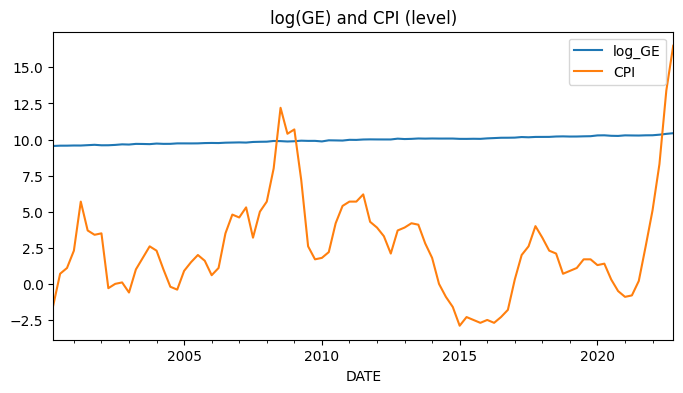


Correlation matrix (main variables):


,log_GE,log_INC,UR,CPI
log_GE,1.000000,0.933920,-0.299180,0.083317
log_INC,0.933920,1.000000,-0.379627,-0.078932
UR,-0.299180,-0.379627,1.000000,0.312613
CPI,0.083317,-0.078932,0.312613,1.000000


In [ ]:
# ============================================================
# 6. Descriptive statistics and simple plots
# ============================================================

print("\nDescriptive statistics (including logs):")
desc_cols = ['GE', 'CPI', 'INC', 'UR', 'log_GE', 'log_INC']
if 'log_CPI' in df.columns:
    desc_cols.append('log_CPI')
display(df[desc_cols].describe().T)

# Plot log_GE vs CPI (or log_CPI)
plt.figure()
if cpi_var_for_model == 'log_CPI':
    df[['log_GE', 'log_CPI']].plot(title='log(GE) and log(CPI)')
else:
    df[['log_GE', 'CPI']].plot(title='log(GE) and CPI (level)')
plt.show()

print("\nCorrelation matrix (main variables):")
corr_cols = ['log_GE', 'log_INC', 'UR']
if 'log_CPI' in df.columns:
    corr_cols.append('log_CPI')
else:
    corr_cols.append('CPI')
display(df[corr_cols].corr())

In [ ]:

# ============================================================
# 7. Baseline regression
# ============================================================

y_baseline = df['log_GE']
X_baseline = sm.add_constant(df[cpi_var_for_model])
model_baseline = sm.OLS(y_baseline, X_baseline).fit()

print("\n=== Baseline Regression ===")
if cpi_var_for_model == 'log_CPI':
    print("Model: log(GE_t) = β0 + β1 log(CPI_t) + ε_t")
else:
    print("Model: log(GE_t) = β0 + β1 CPI_t + ε_t  (CPI in levels)")
print(model_baseline.summary())



=== Baseline Regression ===
Model: log(GE_t) = β0 + β1 CPI_t + ε_t  (CPI in levels)
                            OLS Regression Results                            
Dep. Variable:                 log_GE   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6221
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.432
Time:                        17:14:12   Log-Likelihood:                 4.9218
No. Observations:                  91   AIC:                            -5.844
Df Residuals:                      89   BIC:                           -0.8218
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [ ]:
# ============================================================
# 8. Multiple regression with controls
#    log(GE_t) = β0 + β1 * CPI_term + β2 log(INC_t) + β3 UR_t + ε_t
# ============================================================

regressors = [cpi_var_for_model, 'log_INC', 'UR']
X_multi = sm.add_constant(df[regressors])
y_multi = df['log_GE']

model_multi = sm.OLS(y_multi, X_multi).fit()

print("\n=== Multiple Regression with Controls ===")
if cpi_var_for_model == 'log_CPI':
    print("Model: log(GE_t) = β0 + β1 log(CPI_t) + β2 log(INC_t) + β3 UR_t + ε_t")
else:
    print("Model: log(GE_t) = β0 + β1 CPI_t + β2 log(INC_t) + β3 UR_t + ε_t")
print(model_multi.summary())


=== Multiple Regression with Controls ===
Model: log(GE_t) = β0 + β1 CPI_t + β2 log(INC_t) + β3 UR_t + ε_t
                            OLS Regression Results                            
Dep. Variable:                 log_GE   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     253.0
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           7.59e-43
Time:                        17:15:09   Log-Likelihood:                 108.10
No. Observations:                  91   AIC:                            -208.2
Df Residuals:                      87   BIC:                            -198.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [ ]:
# ============================================================
# 9. Diagnostic Tests
# ============================================================

residuals = model_multi.resid

# 9.1 ADF test
def adf_report(series, name="series"):
    print(f"\nADF Test for {name}:")
    result = adfuller(series, autolag='AIC')
    print(f"  Test statistic: {result[0]:.4f}")
    print(f"  p-value:        {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"  Critical value ({key}): {value:.4f}")

for col in ['log_GE', 'log_INC', 'UR', cpi_var_for_model]:
    adf_report(df[col], name=col)


ADF Test for log_GE:
  Test statistic: 0.5067
  p-value:        0.9851
  Critical value (1%): -3.5069
  Critical value (5%): -2.8950
  Critical value (10%): -2.5846

ADF Test for log_INC:
  Test statistic: -1.6975
  p-value:        0.4324
  Critical value (1%): -3.5088
  Critical value (5%): -2.8958
  Critical value (10%): -2.5850

ADF Test for UR:
  Test statistic: -0.8445
  p-value:        0.8057
  Critical value (1%): -3.5061
  Critical value (5%): -2.8946
  Critical value (10%): -2.5844

ADF Test for CPI:
  Test statistic: -1.2687
  p-value:        0.6434
  Critical value (1%): -3.5127
  Critical value (5%): -2.8975
  Critical value (10%): -2.5859


In [ ]:
# 9.2 VIF
print("\n=== Variance Inflation Factor (VIF) ===")
vif_df = pd.DataFrame()
vif_df["variable"] = ['const'] + regressors
X_for_vif = X_multi.values
vif_values = []
for i in range(X_for_vif.shape[1]):
    vif_values.append(variance_inflation_factor(X_for_vif, i))
vif_df["VIF"] = vif_values
display(vif_df)



=== Variance Inflation Factor (VIF) ===


,variable,VIF
0,const,16273.389394
1,CPI,1.110584
2,log_INC,1.170778
3,UR,1.289503



Durbin–Watson statistic: 0.2567

Plotting ACF and PACF of residuals...


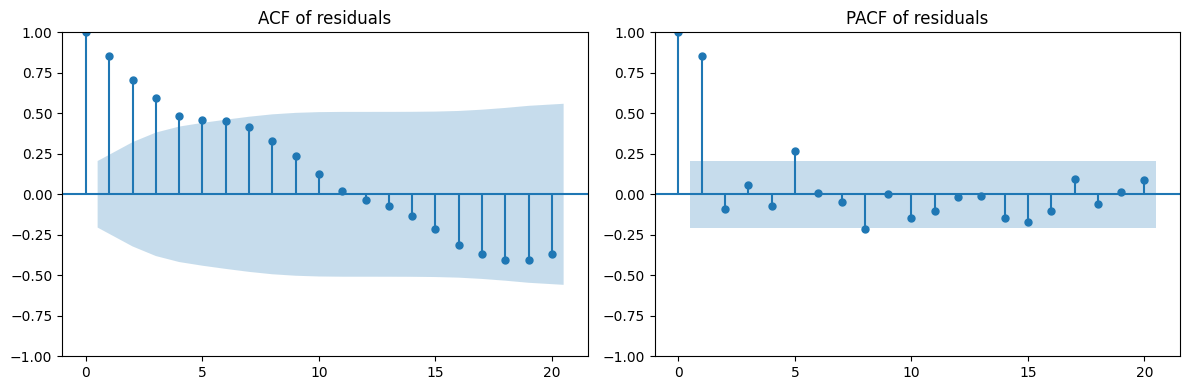

In [ ]:
# 9.3 Durbin–Watson
dw_stat = durbin_watson(residuals)
print(f"\nDurbin–Watson statistic: {dw_stat:.4f}")

# 9.4 Residual ACF/PACF
print("\nPlotting ACF and PACF of residuals...")
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, ax=ax[0], lags=20)
ax[0].set_title("ACF of residuals")
plot_pacf(residuals, ax=ax[1], lags=20)
ax[1].set_title("PACF of residuals")
plt.tight_layout()
plt.show()

In [ ]:

# 9.5 Jarque–Bera
jb_stat, jb_p, _, _ = jarque_bera(residuals)
print("\nJarque–Bera test for residual normality:")
print(f"  JB statistic = {jb_stat:.4f}")
print(f"  p-value      = {jb_p:.4f}")



Jarque–Bera test for residual normality:
  JB statistic = 1.4646
  p-value      = 0.4808


In [ ]:
# 9.6 Breusch–Pagan
bp_test = het_breuschpagan(residuals, X_multi)
bp_labels = ['LM stat', 'LM p-value', 'F stat', 'F p-value']
print("\nBreusch–Pagan test for heteroskedasticity:")
for name, value in zip(bp_labels, bp_test):
    print(f"  {name}: {value:.4f}")


Breusch–Pagan test for heteroskedasticity:
  LM stat: 16.4391
  LM p-value: 0.0009
  F stat: 6.3939
  F p-value: 0.0006


In [ ]:
# ============================================================
# 10. Robustness: Lagged CPI
# ============================================================

if 'log_CPI_lag1' in df.columns and cpi_var_for_model == 'log_CPI':
    regressors_lag = ['log_CPI_lag1', 'log_INC', 'UR']
    X_lag = sm.add_constant(df[regressors_lag])
    model_lag = sm.OLS(df['log_GE'], X_lag).fit()
    print("\n=== Robustness: Lagged log(CPI) Model ===")
    print("Model: log(GE_t) = β0 + β1 log(CPI_{t-1}) + β2 log(INC_t) + β3 UR_t + ε_t")
    print(model_lag.summary())
elif 'CPI_lag1' in df.columns:
    regressors_lag = ['CPI_lag1', 'log_INC', 'UR']
    X_lag = sm.add_constant(df[regressors_lag])
    model_lag = sm.OLS(df['log_GE'], X_lag).fit()
    print("\n=== Robustness: Lagged CPI (level) Model ===")
    print("Model: log(GE_t) = β0 + β1 CPI_{t-1} + β2 log(INC_t) + β3 UR_t + ε_t")
    print(model_lag.summary())



=== Robustness: Lagged CPI (level) Model ===
Model: log(GE_t) = β0 + β1 CPI_{t-1} + β2 log(INC_t) + β3 UR_t + ε_t
                            OLS Regression Results                            
Dep. Variable:                 log_GE   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     232.9
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           1.88e-41
Time:                        17:24:52   Log-Likelihood:                 104.74
No. Observations:                  91   AIC:                            -201.5
Df Residuals:                      87   BIC:                            -191.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [ ]:
# ============================================================
# 11. Sub-sample tests (example: pre/post 2008)
# ============================================================

if isinstance(df.index, pd.DatetimeIndex):
    split_date = '2008-01-01'
    df_pre = df[df.index < split_date]
    df_post = df[df.index >= split_date]

    def run_subsample(sub_df, label):
        if len(sub_df) < 10:
            print(f"\nSubsample '{label}' too small, skipping.")
            return
        X_sub = sm.add_constant(sub_df[regressors])
        y_sub = sub_df['log_GE']
        model_sub = sm.OLS(y_sub, X_sub).fit()
        print(f"\n=== Sub-sample Regression: {label} ===")
        print(model_sub.summary())

    run_subsample(df_pre, "Before 2008")
    run_subsample(df_post, "2008 and after")

print("\n\n✅ Finished: DATE parsing fixed + models, diagnostics, robustness all done.")


=== Sub-sample Regression: Before 2008 ===
                            OLS Regression Results                            
Dep. Variable:                 log_GE   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     181.6
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           5.26e-18
Time:                        17:25:35   Log-Likelihood:                 81.191
No. Observations:                  31   AIC:                            -154.4
Df Residuals:                      27   BIC:                            -148.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   